##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

by [Yousif Ahmed](https://www.linkedin.com/in/yousif-hag-ahmed/) .


# Gemini API: Animated Story Video Generation


<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Animated_Story_Video_Generation_gemini.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This Colab Notebook demonstrates how to generate an animated story video by:

1. Generating a story sequence using structured Google Gemini API (for character consistency).
2. Generating images for each scene using Google’s Imagen API.
3. Synthesizing narration audio using Gemini Live.
4. Creating short video clips (image + audio overlay) for each scene.
5. Combining all clips into one final video.
6. Cleaning up temporary files after processing.


In [ ]:
%pip install google-genai


In [ ]:
import google.generativeai as genai

## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named GOOGLE_API_KEY. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](https://github.com/google-gemini/cookbook/blob/22859a9f498b6de9d8fe4a33161bcdd3f713d5e8/quickstarts/Authentication.ipynb) for an example

In [ ]:
from google.colab import userdata
import os

os.environ['GOOGLE_API_KEY']=userdata.get('GOOGLE_API_KEY')

# Animated Story Video Generation Steps

**1. Story Generation:**

*   **Google Gemini API** is used to generate a sequence of story scenes. Each scene includes an image prompt, audio narration text, and character descriptions. However, to ensure consistency in storytelling and character representation, [Gemini is constrained](https://ai.google.dev/gemini-api/docs/structured-output?lang=python) to respond with JSON, a structured data format.
*   **User Input:** The user provides a theme and the desired number of scenes for their story. This information guides the story generation process.

**2. Image Generation:**

*   **Google Imagen API:** Based on the image prompts generated in the previous step, [Imagen generates images](https://ai.google.dev/gemini-api/docs/imagen) for each scene, bringing the story to life visually. This ensures visually appealing animations with a consistent art style.

**3. Audio Generation:**

*   **Google Gemini Live API:** The narration or dialogue for each scene, generated in the story sequence, is converted to audio using the[ Gemini Live API](https://ai.google.dev/gemini-api/docs/multimodal-live). This adds a voiceover to the animated video, enhancing storytelling.

**4. Video Composition:**

*   [**MoviePy:**](https://zulko.github.io/moviepy/) This open-source Python library is used to combine the generated images and audio to create short video clips for each scene. It is also used to stitch these clips together into a final animated video.

**5. Final Output:**

*   The notebook produces an animated video in MP4 format, bringing together all the elements generated in previous steps.

# **Installation and Setup Commands**

In [ ]:
!apt-get update -qq && apt-get install -qq locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8 LC_ALL=en_US.UTF-8

!apt-get -qq -y install espeak-ng > /dev/null 2>&1
%pip install -q google-generativeai moviepy Pillow
%pip install -q nest_asyncio

## Key Library Explanations:

**MoviePy:** A Python library for video editing, enabling tasks such as:

* Creating video clips from images (`ImageClip`).
* Adding audio to videos (`AudioFileClip`).
* Combining multiple clips (`CompositeVideoClip`, `concatenate_videoclips`).
* Exporting final videos with proper encoding.

**Wave:** A built-in Python library for handling WAV format audio files. It is used in this notebook to:

* Process the audio stream received from Google's API.
* Save the audio stream as WAV files.

**PIL (Python Imaging Library):** A fundamental library for image processing in Python. It's used here to:

* Open and manipulate images generated by Google's Imagen API.
* Save images in various formats.

**Nest_asyncio:** A library that enables the use of asynchronous code (using `async` and `await`) within Jupyter notebooks. This is crucial for:

* Real-time audio generation using Google's Live API, which streams audio data.

In [ ]:
# Core data processing
import os
import json
import numpy as np
from io import BytesIO

# Image handling
from PIL import Image  # For image processing and manipulation
from IPython.display import display

# Video and audio processing
from moviepy.editor import ImageClip, AudioFileClip, CompositeVideoClip, concatenate_videoclips
# MoviePy: Essential for video creation, combining images and audio, and video editing
# Generate and display final video
import time
from IPython.display import HTML
from base64 import b64encode
# Type hints
import typing_extensions as typing

# Async support for Google API calls
import nest_asyncio
nest_asyncio.apply()
import asyncio
import contextlib
import wave  # For WAV audio file handling

# Google Generative AI
from google import genai

# Google Generative Models Setup


v1alpha because you are using the live api to get audio output

In [ ]:
from google import genai
# Using v1alpha for the Live API for audio output. See: https://ai.google.dev/gemini-api/docs/multimodal-live
client = genai.Client(http_options= {
      'api_version': 'v1alpha'
})
# Create a client for text generation using Gemini.
MODEL = "models/gemini-2.5-flash-lite"
# Create a client for image generation using Imagen.
IMAGE_MODEL_ID = "imagen-3.0-generate-002"


# SECTION 1: Story Generation


This code uses Gemini's structured output capabilities to generate story sequences.

use structured output (JSON schema) here to:

1. Ensure consistent formatting across all generated scenes
2. Make it easier to process the output programmatically
3. Force the model to maintain specific fields needed for video generation
4. Prevent inconsistent responses

Each scene includes:
- `image_prompt`: short scene description
- `audio_text`: dialogue or narration text
- `character_description`: detailed character/background hints

Furthermore, the code uses TypedDict for type safety and clear documentation of the expected structure, making it easier to maintain and debug the application.

In [ ]:
# Using structured output to ensure consistent story generation
# See: https://ai.google.dev/gemini-api/docs/structured-output?lang=python

# Define the structure for each story segment using TypedDict for type safety
class StorySegment(typing.TypedDict):
    image_prompt: str
    audio_text: str
    character_description: str

# Define the overall story response structure
class StoryResponse(typing.TypedDict):
    complete_story: list[StorySegment]
    pages: int

def generate_story_sequence(complete_story: str, pages: int) -> list[StorySegment]:
    response = client.models.generate_content(
        model=MODEL,
        contents=f'''you are an animation video producer. Generate a story sequence about {complete_story} in {pages} scenes (with interactions and characters), 1 sec each scene. Write:

image_prompt:(define art style for kids animation(consistent for all the characters), no violence) a full description of the scene, the characters in it, and the background in 20 words or less. Progressively shift the scene as the story advances.
audio_text: a one-sentence dialogue/narration for the scene.
character_description: no people ever, only animals and objects. Describe all characters (consistent names, features, clothing, etc.) with an art style reference (e.g., "Pixar style," "photorealistic," "Ghibli") in 30 words or less.
''',
        config={
            'response_mime_type': 'application/json',
            'response_schema': list[StoryResponse]
        }
    )

    try:
        story_data_text = response.text  # Get the JSON text
        story_data_list = json.loads(story_data_text)
        if isinstance(story_data_list, list) and len(story_data_list) > 0:
            story_data = story_data_list[0]
            return story_data.get('complete_story', []), story_data.get('character_description', {})
        else:
            return []
    except (KeyError, TypeError, IndexError, json.JSONDecodeError) as e:
        print(f"Error parsing JSON: {e}")
        return []


Example Usage: Define a Theme and Generate Scenes
Write your own theme and number of scenes to play and experiment with it.

In [ ]:
# @title Generate Story Segments
theme = "a cat and a dog playing " #@param {type:"string"}
num_scenes = 3 #@param {type:"slider", min:1, max:10, step:1}

story_segments, _ = generate_story_sequence(theme, num_scenes)
print("\nGenerated Story Segments:")
print(json.dumps(story_segments, indent=2))


Generated Story Segments:
[
  {
    "audio_text": "Whiskers the cat pounces playfully, startling Buster the dog in the sunny garden.",
    "character_description": "Whiskers: A playful ginger cat with big green eyes. Art style: Simple, rounded shapes, bright colors, kid-friendly animation style. Buster: A golden retriever puppy, floppy ears, big paws. Art style: Same as Whiskers.",
    "image_prompt": "Kids animation style: Whiskers jumps at Buster in a flower filled garden with a blue fence."
  },
  {
    "audio_text": "Buster wags his tail and chases Whiskers around a colorful mushroom house.",
    "character_description": "Whiskers: A playful ginger cat with big green eyes. Art style: Simple, rounded shapes, bright colors, kid-friendly animation style. Buster: A golden retriever puppy, floppy ears, big paws. Art style: Same as Whiskers.",
    "image_prompt": "Kids animation style: Buster chases Whiskers around a red mushroom house with white spots."
  },
  {
    "audio_text": "Toge

# SECTION 2: Image and Audio Generation

In [ ]:
@contextlib.contextmanager
def wave_file(filename, channels=1, rate=24000, sample_width=2):
    with wave.open(filename, "wb") as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(sample_width)
        wf.setframerate(rate)
        yield wf


In [ ]:
# --- Cell 2: Definitions and setup ---
temp_audio_files = []  # To track temporary audio files
temp_image_files = []  # To track temporary image files
video_clips = []       # To store individual video clips for each scene

def generate_audio_live(api_text, output_filename):
    import asyncio
    collected_audio = bytearray()

    async def _generate():
        config = {
            "response_modalities": ["AUDIO"]
        }
        # Connect to the Live API using the client already initialized above.
        async with client.aio.live.connect(model=MODEL, config=config) as session:
            # Send the audio_text prompt; mark as end_of_turn.
            await session.send(input=api_text, end_of_turn=True)
            # Collect audio data as it streams in.
            async for response in session.receive():
                if response.data:
                    collected_audio.extend(response.data)
        return bytes(collected_audio)

    # Run the async function and collect the audio bytes.
    audio_bytes = asyncio.run(_generate())
    # Write the collected audio bytes into a WAV file using the helper.
    with wave_file(output_filename) as wf:
        wf.writeframes(audio_bytes)
    return output_filename



# Note: Use a system instruction to prevent common AI responses and ensure natural narration
audio_negative_prompt = "don't say OK , I will do this or that, just only read this story using voice expressions without introductions or ending ,more segments are coming ,don't say OK , I will do this or that:\n"


Processing scene 0:
Image Prompt: Kids animation style: Whiskers jumps at Buster in a flower filled garden with a blue fence.
Audio Text: Whiskers the cat pounces playfully, startling Buster the dog in the sunny garden.
Character Description: Whiskers: A playful ginger cat with big green eyes. Art style: Simple, rounded shapes, bright colors, kid-friendly animation style. Buster: A golden retriever puppy, floppy ears, big paws. Art style: Same as Whiskers.
--------------------------------


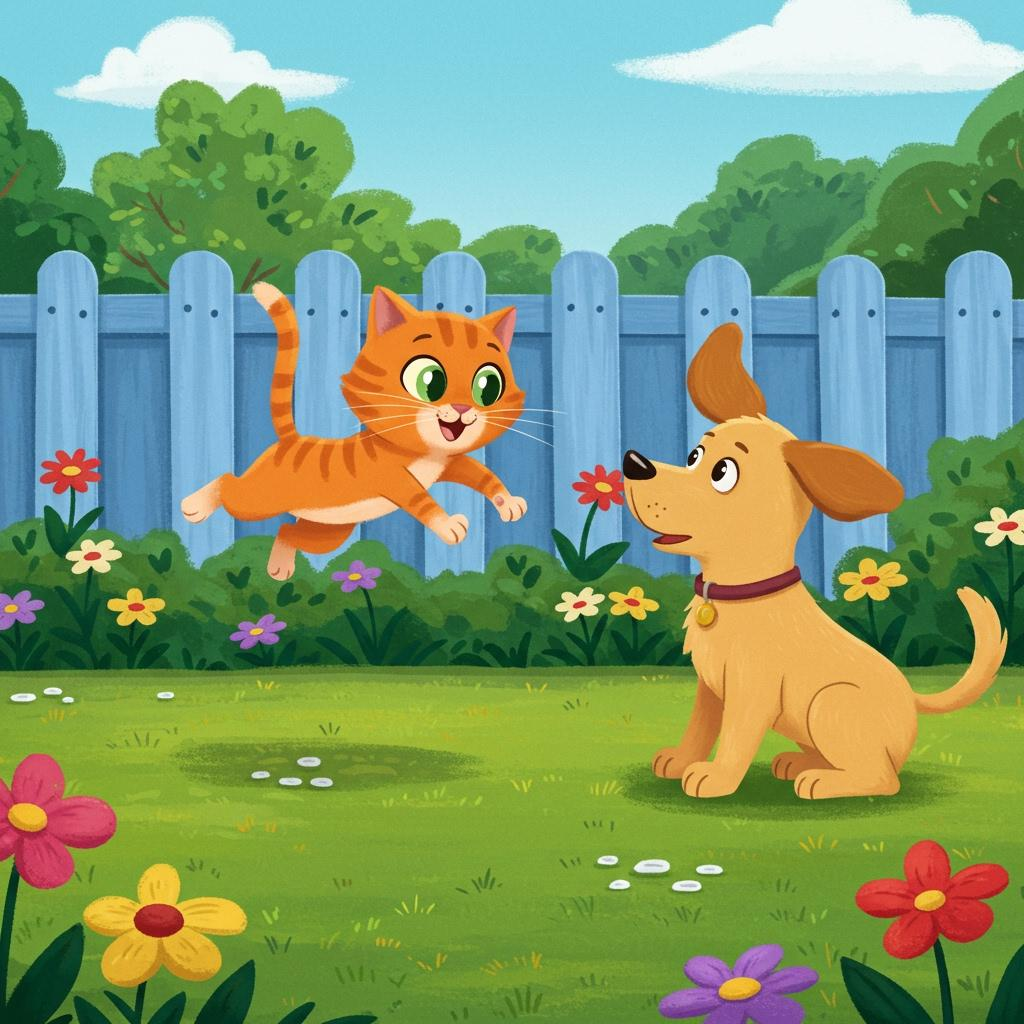

Processing scene 1:
Image Prompt: Kids animation style: Buster chases Whiskers around a red mushroom house with white spots.
Audio Text: Buster wags his tail and chases Whiskers around a colorful mushroom house.
Character Description: Whiskers: A playful ginger cat with big green eyes. Art style: Simple, rounded shapes, bright colors, kid-friendly animation style. Buster: A golden retriever puppy, floppy ears, big paws. Art style: Same as Whiskers.
--------------------------------


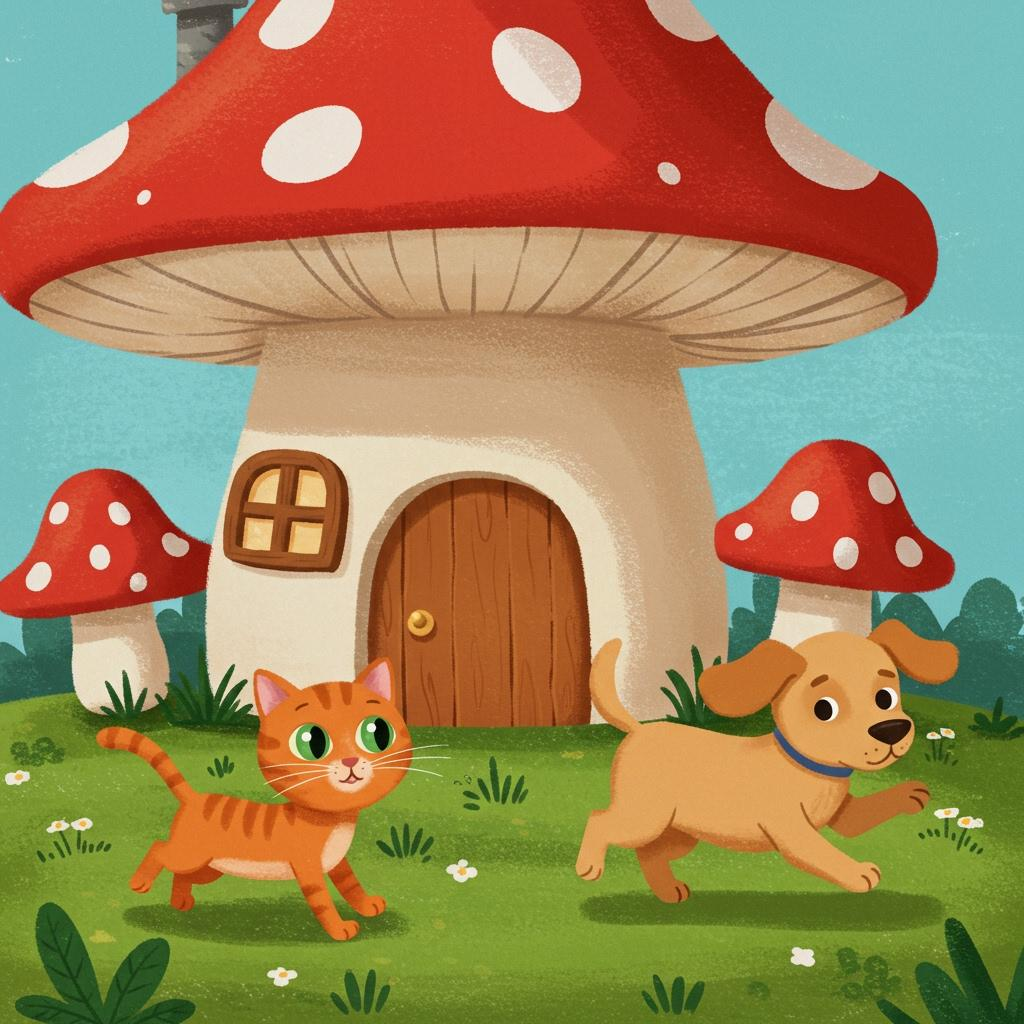

Processing scene 2:
Image Prompt: Kids animation style: Whiskers and Buster slide down a rainbow into a toy-filled pool.
Audio Text: Together, Whiskers and Buster slide down a rainbow into a pool filled with toys.
Character Description: Whiskers: A playful ginger cat with big green eyes. Art style: Simple, rounded shapes, bright colors, kid-friendly animation style. Buster: A golden retriever puppy, floppy ears, big paws. Art style: Same as Whiskers.
--------------------------------


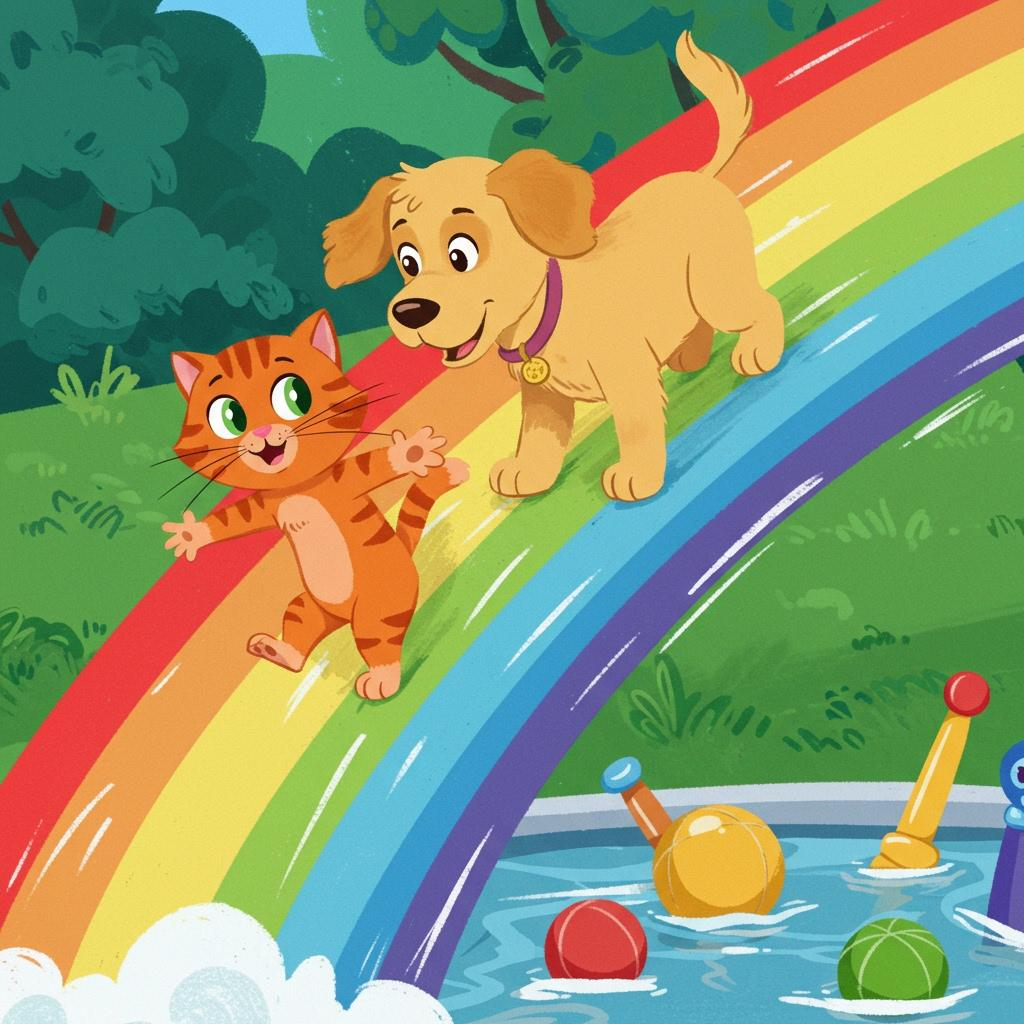

In [ ]:
# --- Cell 3: Main processing loop ---
for i, segment in enumerate(story_segments):
    # Retrieve details for the current scene.
    image_prompt = segment['image_prompt']
    audio_text =  audio_negative_prompt + segment['audio_text']
    audio_text_prompt = segment['audio_text']
    char_desc = segment['character_description']
    print(f"Processing scene {i}:")
    print("Image Prompt:", image_prompt)
    print("Audio Text:", audio_text_prompt)
    print("Character Description:", char_desc)
    print("--------------------------------")

    # -------------------------
    # Image Generation using Google Imagen
    # -------------------------
    combined_prompt = "detailed children book animation style " + image_prompt + " " + char_desc

    result = client.models.generate_images(
        model=IMAGE_MODEL_ID,
        prompt=combined_prompt,
        config={
            "number_of_images": 1,
            "output_mime_type": "image/jpeg",
            "person_generation": "DONT_ALLOW",
            "aspect_ratio": "1:1"
        }
    )

    try:
        if not result.generated_images:
            raise ValueError("No images were generated. The prompt might have been flagged as harmful. Please modify your prompt and try again.")
        for generated_image in result.generated_images:
            image = Image.open(BytesIO(generated_image.image.image_bytes))
    except Exception as e:
        print("Image generation failed ", e)

    image_path = f"image_{i}.png"
    image.save(image_path)
    temp_image_files.append(image_path)
    display(image)

    # -------------------------
    # Audio Generation using Google Live API
    # -------------------------
    audio_path = f"audio_{i}.wav"
    audio_path = generate_audio_live(audio_text, audio_path)
    temp_audio_files.append(audio_path)


    # -------------------------
    # Create Video Clip (Image + Audio)
    # -------------------------
    audio_clip = AudioFileClip(audio_path)

    # Convert PIL Image to numpy array
    np_image = np.array(image)

    # Create ImageClip (size is inferred from np_image)
    image_clip = ImageClip(np_image).set_duration(audio_clip.duration)

    # Store composite clip with audio in memory
    composite_clip = CompositeVideoClip([image_clip]).set_audio(audio_clip)
    video_clips.append(composite_clip)

# SECTION 3: Final Video Assembly and Cleanup


In [ ]:
final_video = concatenate_videoclips(video_clips)
output_filename = f"{int(time.time())}_output_video.mp4"
print("Writing final video to", output_filename)
final_video.write_videofile(output_filename, fps=24)

# Display the video in the notebook
def show_video(video_path):
    """Display video in notebook"""
    video_file = open(video_path, "rb")
    video_bytes = video_file.read()
    video_b64 = b64encode(video_bytes).decode()
    video_tag = f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_b64}" type="video/mp4"></video>'
    return HTML(video_tag)

# Show the video
display(show_video(output_filename))

# Cleanup: Close video clips and remove temporary files
final_video.close()
for clip in video_clips:
    clip.close()
for file in temp_audio_files:
    os.remove(file)
for file in temp_image_files:
    os.remove(file)


# A video player will appear below

Writing final video to 1740512475_output_video.mp4
Moviepy - Building video 1740512475_output_video.mp4.
MoviePy - Writing audio in 1740512475_output_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video 1740512475_output_video.mp4



Moviepy - Done !
Moviepy - video ready 1740512475_output_video.mp4


## Final Notes

This notebook is designed to run without modifications. It generates an animated story video using multiple Google APIs and open source libraries. Make sure to have a valid API key and to install all the necessary dependencies before running the notebook in Google Colab.


If you like to view premade videos using this concept, Checkout this [website](https://www.vastai.ai/).

## Next Steps
### Useful API References:

* Learn more about [Structured Outputs](https://ai.google.dev/gemini-api/docs/structured-outputs) in the docs.

* [Imagen Pricing](https://ai.google.dev/pricing#2_0flash)

* [Imagen Prompt Guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide)

### Related Examples

* [Get Started with Imagen](../quickstarts/Get_started_imagen.ipynb)
* [Book Illustration Generation](../examples/Book_illustration.ipynb)
* [Get Started with Live API](../quickstarts/Get_started_LiveAPI_tools.ipynb)

### Continue Your Discovery of the Gemini API

Check out other great Gemini features:

* [Video Understanding](../quickstarts/Video_understanding.ipynb)
* [Prompting with Video](../quickstarts/Video.ipynb)


[Contact Contributor](https://github.com/Yousif-GO)